# Open-Endedness and General Intelligence Project Demo (Group 10)

## Instructions

### Codebase
You can find the full implementation of PALMER and training pipelines in our GitHub repository:
https://github.com/RichardHuang24/PALMER-RL-Agent

### Project Report
A detailed explanation of our motivation, architecture, experiments, and results is available in our report:


### Demo Overview

This Colab notebook presents an interactive demo of our memory-augmented reinforcement learning architecture, PALMER, tested on the MiniGrid-Memory environments.

In this demo, we will:


*   Load and visualize Success Rate and Mean Episode Length for all 4 environments.
*  Analyze PALMER’s internal behavior using Gating Weights and Loss metrics
*  Show qualitative video demos of PALMER’s behavior.
* Compare PALMER against two baselines: PPO-LSTM and PPO-TrXL.

🧠 PALMER (Parallel Attentive LSTM-Transformer) is designed to handle memory-intensive tasks in partially observable environments by fusing short- and long-term memory using a learnable gating mechanism.

---



## MiniGrid-Memory Environments

This demo evaluates **PALMER** in four memory-centric environments from the [MiniGrid benchmark suite](https://minigrid.farama.org/environments/minigrid/MemoryEnv/).  
In each task, the agent must **observe a target color** at the start and **choose the correct door later** based on memory.

### Environment Overview

| **Environment** | **Description** |
|-----------------|-----------------|
| `S11`           | A simple, deterministic layout with one memory cue and a short path to decision. |
| `S13`           | Slightly more complex deterministic layout with added distractor doors. |
| `S13Random`     | Similar to S13, but with random target color and room layout in each episode. |
| `S17Random`     | Most complex: deeper mazes, more distractors, and randomization in layout and cue. |


These environments test both:

- **Short-term memory**: retaining info through simple navigation  
- **Long-term/generalized memory**: recalling the cue after long, distractor-filled trajectories

> ℹ️ All environments are partially observable — the agent sees only a limited field of view at each step, so memory is essential for solving the task.




---


## Environment & Model Setup

In this section, we install necessary dependencies and set up our connection to Weights & Biases (WandB) to load the results for visualization. All training was conducted using the CleanRL framework. (Link: https://github.com/vwxyzjn/cleanrl)

We’ll use the WandB API to directly access logs from our training runs, including metrics like success rate, episode length, and internal PALMER statistics.

---

### Success Rate & Mean Episode Length
To evaluate the agent’s performance, we track two key metrics during training:

*   Success Rate: The proportion of episodes in which the agent correctly completes the task that is selecting the right door based on its memory of the initial cue.

*   Mean Episode Length: The average number of steps the agent takes to finish an episode. Lower values indicate more efficient decision-making and navigation.

### Value Loss Analysis
The value loss measures the error between the predicted state-value and the actual return. A decreasing value loss over time indicates that the agent is learning to better estimate the value of its current state, which is crucial for stable policy updates in PPO-based training.




In [12]:
# Install Dependencies
!pip install wandb matplotlib -q

# Import Libraries
import wandb
from wandb.apis import PublicApi
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from base64 import b64encode

# Initialize WandB API
api = wandb.Api()

# Set project and entity
ENTITY = "ziruihuang07-ucl"
PROJECT = "cleanRL"


## Results: MiniGrid-MemoryS11

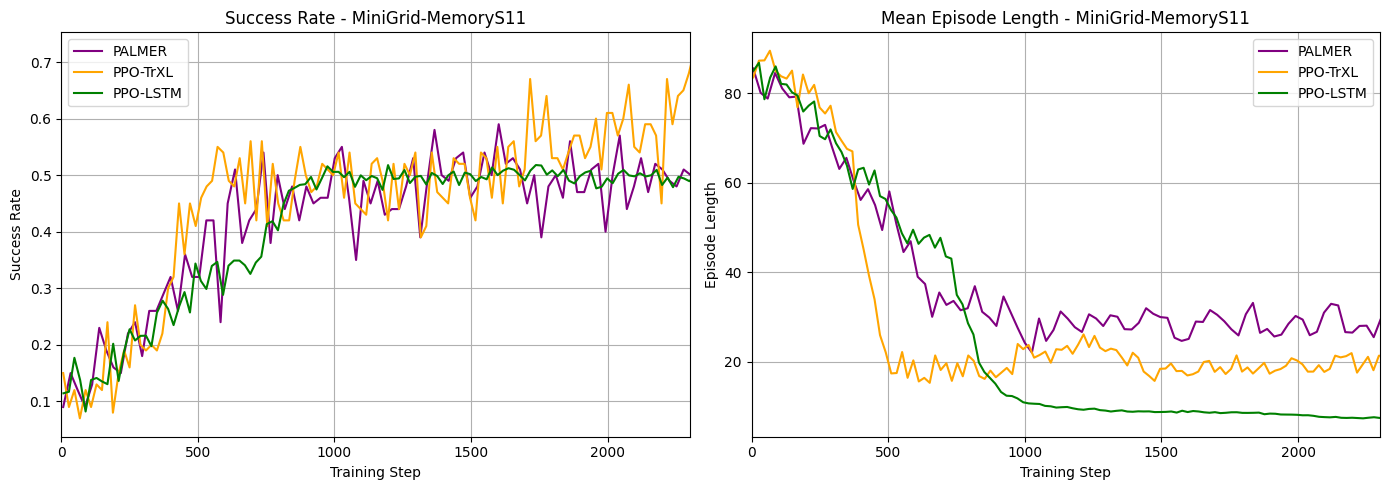

In [14]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS11-v0"
ARCH_LABELS = {
    "ppo_lstm": "PPO-LSTM",
    "ppo_trxl": "PPO-TrXL",
    "palmer": "PALMER"
}
COLORS = {
    "ppo_lstm": "green",
    "ppo_trxl": "orange",
    "palmer": "purple"
}

# --- Filter S11 runs ---
s11_runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name]

# --- Plotting ---
plt.figure(figsize=(14, 5))

# --- Success Rate Plot ---
plt.subplot(1, 2, 1)
for run in s11_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/success_rate"])
    plt.plot(hist["_step"], hist["evals/success_rate"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Success Rate - MiniGrid-MemoryS11")
plt.xlabel("Training Step")
plt.ylabel("Success Rate")
plt.xlim([0, 2300])
plt.legend()
plt.grid(True)

# --- Episode Length Plot ---
plt.subplot(1, 2, 2)
for run in s11_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/episode_length"])
    plt.plot(hist["_step"], hist["evals/episode_length"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Mean Episode Length - MiniGrid-MemoryS11")
plt.xlabel("Training Step")
plt.ylabel("Episode Length")
plt.xlim([0, 2300])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


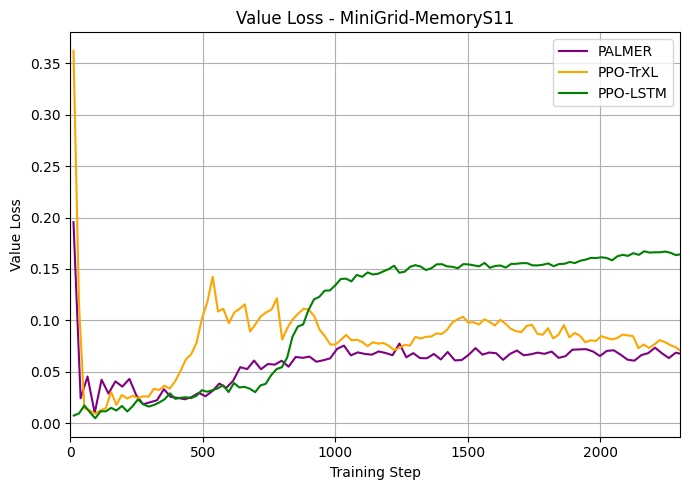

In [26]:
# --- Plot Value Loss ---
plt.figure(figsize=(7, 5))
for run in s11_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch:
        continue
    history = run.history(keys=["_step", "losses/value_loss"])
    plt.plot(history["_step"], history["losses/value_loss"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Value Loss - MiniGrid-MemoryS11")
plt.xlabel("Training Step")
plt.ylabel("Value Loss")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Video for RL Agents Before Training for Three Architectures
### (MiniGrid-MemoryS11)

In [91]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS11-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]

# --- Function to extract training step from video filename ---
def extract_step(file_name):
    match = re.search(r"step-(\d+)", file_name)
    return int(match.group(1)) if match else -1

# --- Collect final video for each architecture ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]  # assume latest run
    video_files = [f for f in run.files() if f.name.endswith(".mp4")]

    # Select video with max training step
    if video_files:
        final_video = max(video_files, key=lambda f: extract_step(f.name))
        final_video.download(replace=True)
        video_data[arch] = final_video.name

# --- Display side-by-side videos ---
video_html = ""
for arch, file_name in video_data.items():
    with open(file_name, "rb") as f:
        encoded = b64encode(f.read()).decode("ascii")
        video_html += f"""
        <div style="display:inline-block; margin-right:20px;">
            <h4>{arch.upper()}</h4>
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video>
        </div>
        """

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))

### Videos for RL Agent after training for Three Architectures
### (MiniGrid-MemoryS11)

In [88]:
# --- Configuration ---
TARGET_SUFFIXES = {"50.mp4", "8c.mp4", "f33.mp4"}

# --- Collect videos matching suffixes ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]
    mp4_files = list(run.files())

    selected_videos = [f for f in mp4_files if f.name.endswith(tuple(TARGET_SUFFIXES))]

    video_data[arch] = []
    for vid in selected_videos:
        vid.download(replace=True)
        video_data[arch].append(vid.name)

# --- Display videos side-by-side ---
video_html = ""
for arch, file_list in video_data.items():
    block = f"<div style='margin-right:30px;'><h4>{arch.upper()}</h4>"
    for file_name in file_list:
        with open(file_name, "rb") as f:
            encoded = b64encode(f.read()).decode("ascii")
            block += f"""
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video><br>
            """
    block += "</div>"
    video_html += block

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))


## Results: MiniGrid-MemoryS13

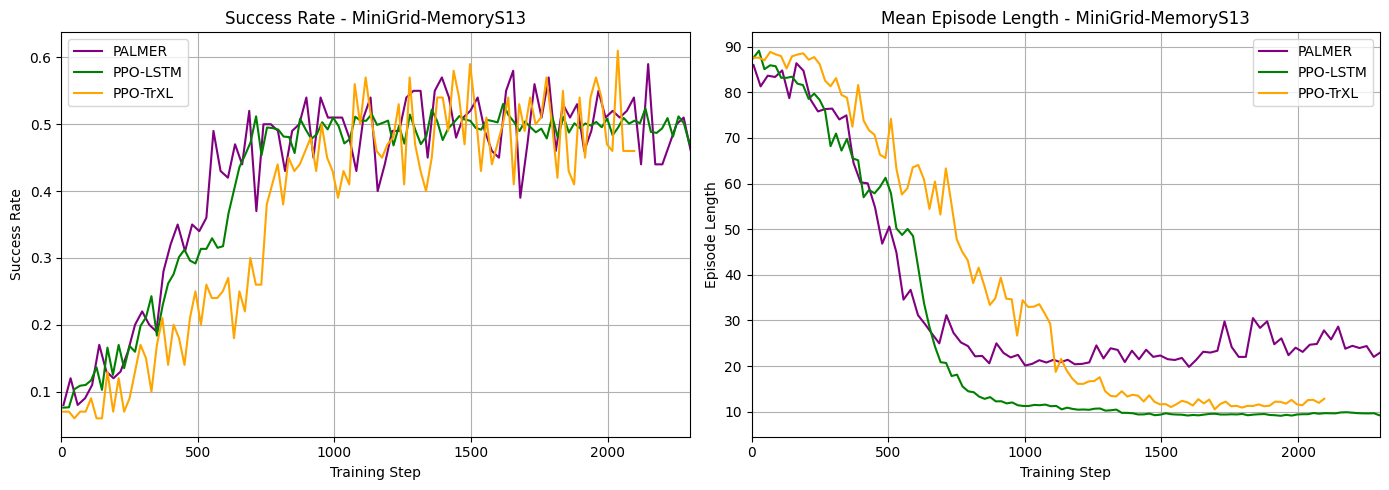

In [16]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13-v0"
ARCH_LABELS = {
    "ppo_lstm": "PPO-LSTM",
    "ppo_trxl": "PPO-TrXL",
    "palmer": "PALMER"
}
COLORS = {
    "ppo_lstm": "green",
    "ppo_trxl": "orange",
    "palmer": "purple"
}

# --- Filter S13 runs ---
s13_runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name]

# --- Plotting ---
plt.figure(figsize=(14, 5))

# Success Rate Plot
plt.subplot(1, 2, 1)
for run in s13_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/success_rate"])
    plt.plot(hist["_step"], hist["evals/success_rate"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Success Rate - MiniGrid-MemoryS13")
plt.xlabel("Training Step")
plt.ylabel("Success Rate")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)

# Episode Length Plot
plt.subplot(1, 2, 2)
for run in s13_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/episode_length"])
    plt.plot(hist["_step"], hist["evals/episode_length"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Mean Episode Length - MiniGrid-MemoryS13")
plt.xlabel("Training Step")
plt.ylabel("Episode Length")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


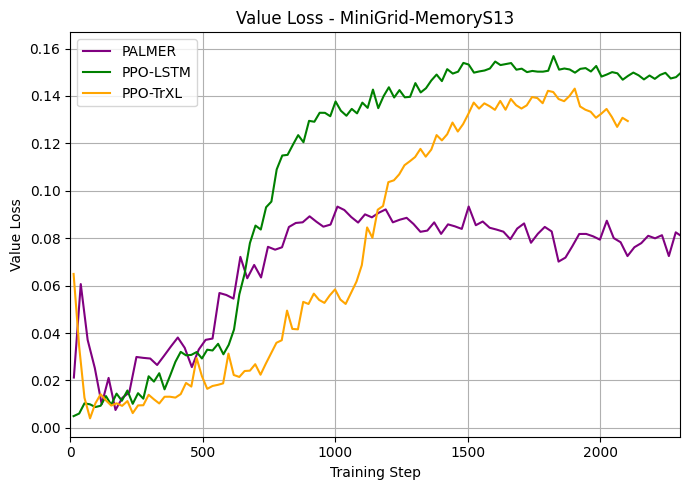

In [27]:
# --- Plot Value Loss ---
plt.figure(figsize=(7, 5))
for run in s13_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch:
        continue
    history = run.history(keys=["_step", "losses/value_loss"])
    plt.plot(history["_step"], history["losses/value_loss"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Value Loss - MiniGrid-MemoryS13")
plt.xlabel("Training Step")
plt.ylabel("Value Loss")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Videos for RL Agent Before training for Three Architectures
### (MiniGrid-MemoryS13)

In [92]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]

# --- Function to extract training step from video filename ---
def extract_step(file_name):
    match = re.search(r"step-(\d+)", file_name)
    return int(match.group(1)) if match else -1

# --- Collect final video for each architecture ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]  # assume latest run
    video_files = [f for f in run.files() if f.name.endswith(".mp4")]

    # Select video with max training step
    if video_files:
        final_video = max(video_files, key=lambda f: extract_step(f.name))
        final_video.download(replace=True)
        video_data[arch] = final_video.name

# --- Display side-by-side videos ---
video_html = ""
for arch, file_name in video_data.items():
    with open(file_name, "rb") as f:
        encoded = b64encode(f.read()).decode("ascii")
        video_html += f"""
        <div style="display:inline-block; margin-right:20px;">
            <h4>{arch.upper()}</h4>
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video>
        </div>
        """

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))

### Videos for RL Agent after training for Three Architectures
### (MiniGrid-MemoryS13)

In [93]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]
TARGET_SUFFIXES = {"55.mp4", "2427.mp4", "7a7e.mp4"}
api = wandb.Api()

# --- Collect videos matching suffixes ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]
    mp4_files = list(run.files())

    selected_videos = [f for f in mp4_files if f.name.endswith(tuple(TARGET_SUFFIXES))]

    video_data[arch] = []
    for vid in selected_videos:
        vid.download(replace=True)
        video_data[arch].append(vid.name)

# --- Display videos side-by-side ---
video_html = ""
for arch, file_list in video_data.items():
    block = f"<div style='margin-right:30px;'><h4>{arch.upper()}</h4>"
    for file_name in file_list:
        with open(file_name, "rb") as f:
            encoded = b64encode(f.read()).decode("ascii")
            block += f"""
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video><br>
            """
    block += "</div>"
    video_html += block

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))


## Results: MiniGrid-Memory-S13Random

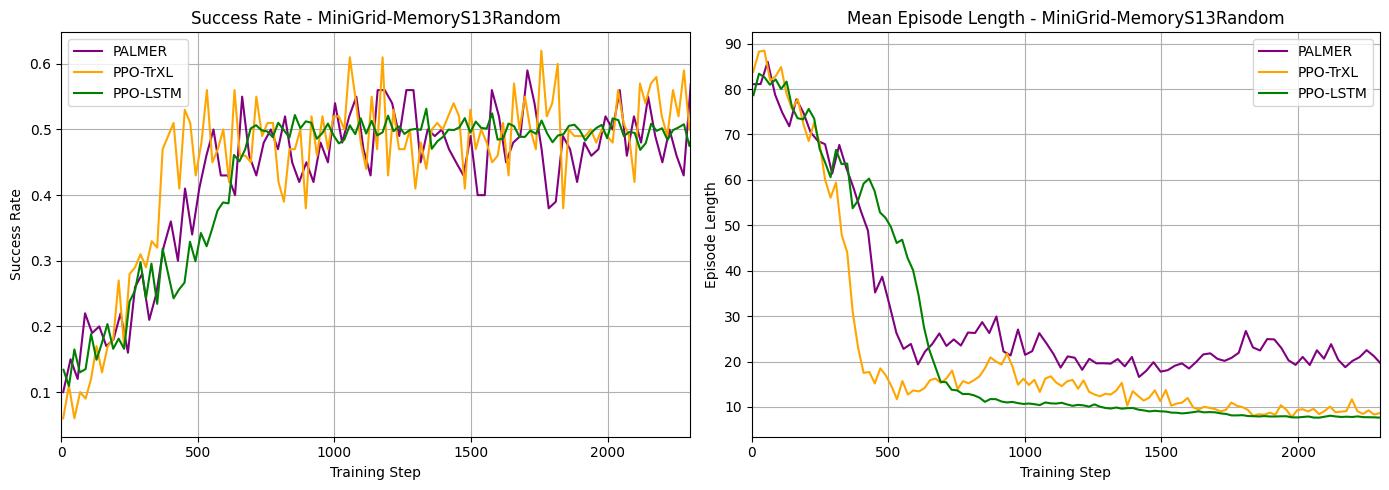

In [35]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13Random-v0"
ARCH_LABELS = {
    "ppo_lstm": "PPO-LSTM",
    "ppo_trxl": "PPO-TrXL",
    "palmer": "PALMER"
}
COLORS = {
    "ppo_lstm": "green",
    "ppo_trxl": "orange",
    "palmer": "purple"
}

# --- Filter S13Random runs ---
s13r_runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name]

# --- Plotting ---
plt.figure(figsize=(14, 5))

# Success Rate Plot
plt.subplot(1, 2, 1)
for run in s13r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/success_rate"])
    plt.plot(hist["_step"], hist["evals/success_rate"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Success Rate - MiniGrid-MemoryS13Random")
plt.xlabel("Training Step")
plt.ylabel("Success Rate")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)

# Episode Length Plot
plt.subplot(1, 2, 2)
for run in s13r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/episode_length"])
    plt.plot(hist["_step"], hist["evals/episode_length"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Mean Episode Length - MiniGrid-MemoryS13Random")
plt.xlabel("Training Step")
plt.ylabel("Episode Length")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


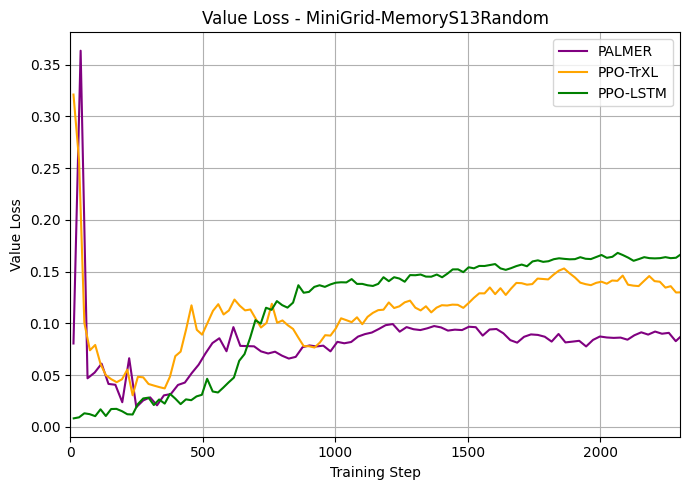

In [36]:
# --- Plot Value Loss ---
plt.figure(figsize=(7, 5))
for run in s13r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch:
        continue
    history = run.history(keys=["_step", "losses/value_loss"])
    plt.plot(history["_step"], history["losses/value_loss"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Value Loss - MiniGrid-MemoryS13Random")
plt.xlabel("Training Step")
plt.ylabel("Value Loss")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Videos for RL Agent Before training for Three Architectures
### (MiniGrid-MemoryS13Random)

In [94]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13Random-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]

# --- Function to extract training step from video filename ---
def extract_step(file_name):
    match = re.search(r"step-(\d+)", file_name)
    return int(match.group(1)) if match else -1

# --- Collect final video for each architecture ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]  # assume latest run
    video_files = [f for f in run.files() if f.name.endswith(".mp4")]

    # Select video with max training step
    if video_files:
        final_video = max(video_files, key=lambda f: extract_step(f.name))
        final_video.download(replace=True)
        video_data[arch] = final_video.name

# --- Display side-by-side videos ---
video_html = ""
for arch, file_name in video_data.items():
    with open(file_name, "rb") as f:
        encoded = b64encode(f.read()).decode("ascii")
        video_html += f"""
        <div style="display:inline-block; margin-right:20px;">
            <h4>{arch.upper()}</h4>
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video>
        </div>
        """

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))

### Videos for RL Agent After training for Three Architectures
### (MiniGrid-MemoryS13Random)

In [96]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS13Random-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]
TARGET_SUFFIXES = {"8750.mp4", "405e.mp4", "6df0.mp4"}
api = wandb.Api()

# --- Collect videos matching suffixes ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]
    mp4_files = list(run.files())

    selected_videos = [f for f in mp4_files if f.name.endswith(tuple(TARGET_SUFFIXES))]

    video_data[arch] = []
    for vid in selected_videos:
        vid.download(replace=True)
        video_data[arch].append(vid.name)

# --- Display videos side-by-side ---
video_html = ""
for arch, file_list in video_data.items():
    block = f"<div style='margin-right:30px;'><h4>{arch.upper()}</h4>"
    for file_name in file_list:
        with open(file_name, "rb") as f:
            encoded = b64encode(f.read()).decode("ascii")
            block += f"""
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video><br>
            """
    block += "</div>"
    video_html += block

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))


## Results: MiniGrid-Memory-S17Random

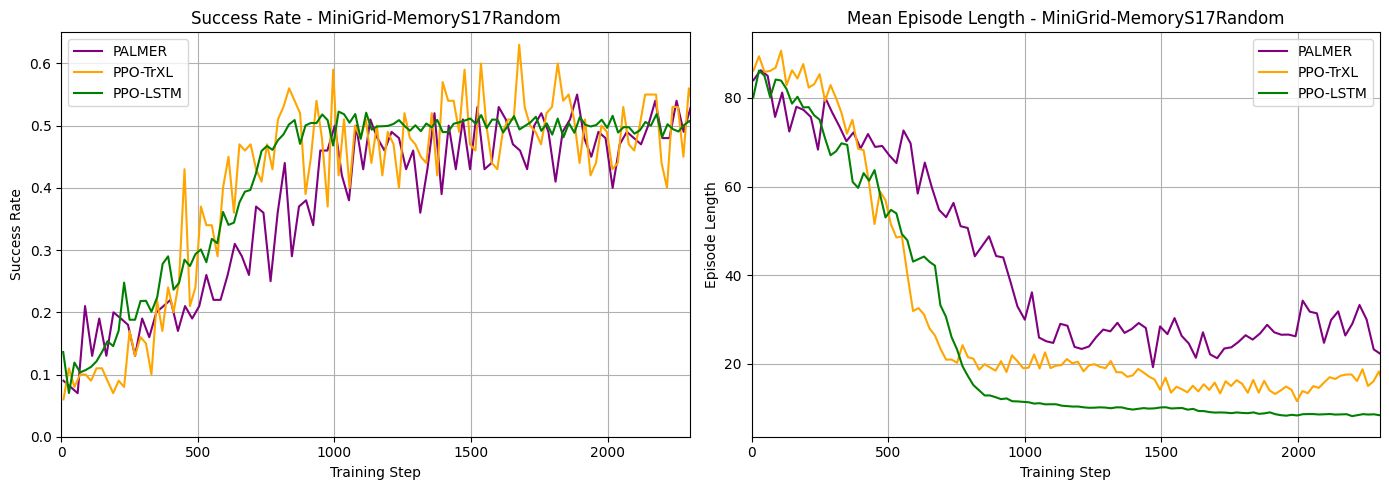

In [31]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS17Random-v0"
ARCH_LABELS = {
    "ppo_lstm": "PPO-LSTM",
    "ppo_trxl": "PPO-TrXL",
    "palmer": "PALMER"
}
COLORS = {
    "ppo_lstm": "green",
    "ppo_trxl": "orange",
    "palmer": "purple"
}

# --- Filter S17Random runs ---
s17r_runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name]

# --- Plotting ---
plt.figure(figsize=(14, 5))

# Success Rate Plot
plt.subplot(1, 2, 1)
for run in s13r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/success_rate"])
    plt.plot(hist["_step"], hist["evals/success_rate"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Success Rate - MiniGrid-MemoryS17Random")
plt.xlabel("Training Step")
plt.ylabel("Success Rate")
plt.xlim(0, 2300)
plt.ylim(0,0.65)
plt.legend()
plt.grid(True)

# Episode Length Plot
plt.subplot(1, 2, 2)
for run in s13r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch: continue
    hist = run.history(keys=["_step", "evals/episode_length"])
    plt.plot(hist["_step"], hist["evals/episode_length"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Mean Episode Length - MiniGrid-MemoryS17Random")
plt.xlabel("Training Step")
plt.ylabel("Episode Length")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


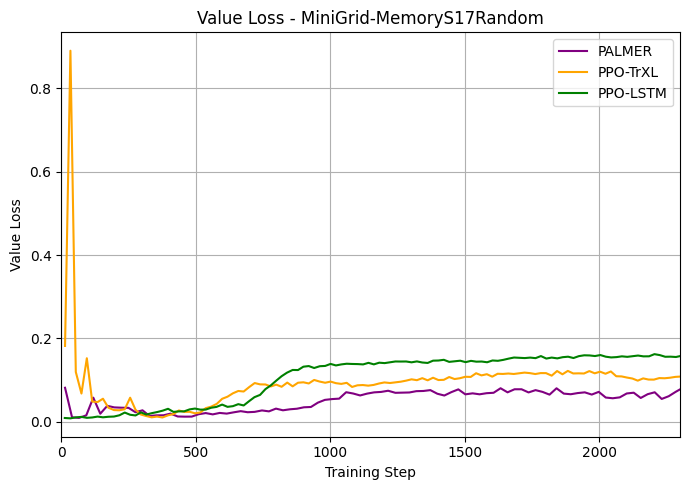

In [33]:
# --- Plot Value Loss ---
plt.figure(figsize=(7, 5))
for run in s17r_runs:
    arch = next((key for key in ARCH_LABELS if key in run.name), None)
    if not arch:
        continue
    history = run.history(keys=["_step", "losses/value_loss"])
    plt.plot(history["_step"], history["losses/value_loss"], label=ARCH_LABELS[arch], color=COLORS[arch])
plt.title("Value Loss - MiniGrid-MemoryS17Random")
plt.xlabel("Training Step")
plt.ylabel("Value Loss")
plt.xlim(0, 2300)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Videos for RL Agent Before training for Three Architectures
### (MiniGrid-MemoryS17Random)

In [97]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS17Random-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]

# --- Function to extract training step from video filename ---
def extract_step(file_name):
    match = re.search(r"step-(\d+)", file_name)
    return int(match.group(1)) if match else -1

# --- Collect final video for each architecture ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]  # assume latest run
    video_files = [f for f in run.files() if f.name.endswith(".mp4")]

    # Select video with max training step
    if video_files:
        final_video = max(video_files, key=lambda f: extract_step(f.name))
        final_video.download(replace=True)
        video_data[arch] = final_video.name

# --- Display side-by-side videos ---
video_html = ""
for arch, file_name in video_data.items():
    with open(file_name, "rb") as f:
        encoded = b64encode(f.read()).decode("ascii")
        video_html += f"""
        <div style="display:inline-block; margin-right:20px;">
            <h4>{arch.upper()}</h4>
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video>
        </div>
        """

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))

### Videos for RL Agent After training for Three Architectures
### (MiniGrid-MemoryS17Random)

In [99]:
# --- Configuration ---
ENV_NAME = "MiniGrid-MemoryS17Random-v0"
ARCH_KEYS = ["ppo_lstm", "ppo_trxl", "palmer"]
TARGET_SUFFIXES = {"7741.mp4", "bb459.mp4", "b17b.mp4"}
api = wandb.Api()

# --- Collect videos matching suffixes ---
video_data = {}
for arch in ARCH_KEYS:
    runs = [r for r in api.runs(f"{ENTITY}/{PROJECT}") if ENV_NAME in r.name and arch in r.name]
    if not runs:
        continue
    run = runs[0]
    mp4_files = list(run.files())

    selected_videos = [f for f in mp4_files if f.name.endswith(tuple(TARGET_SUFFIXES))]

    video_data[arch] = []
    for vid in selected_videos:
        vid.download(replace=True)
        video_data[arch].append(vid.name)

# --- Display videos side-by-side ---
video_html = ""
for arch, file_list in video_data.items():
    block = f"<div style='margin-right:30px;'><h4>{arch.upper()}</h4>"
    for file_name in file_list:
        with open(file_name, "rb") as f:
            encoded = b64encode(f.read()).decode("ascii")
            block += f"""
            <video width="300" height="240" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video><br>
            """
    block += "</div>"
    video_html += block

display(HTML(f"<div style='display:flex; justify-content:space-around;'>{video_html}</div>"))


## Gate Weight (PALMER Architecture)

### PALMER Gating Mechanism Analysis

PALMER fuses outputs from its LSTM (short-term memory) and Transformer (long-term memory) branches using a **learned gating weight**
\( g ∈ [0, 1] \).

- A **lower** gate value \( g \) → more reliance on the **LSTM** (working memory).
- A **higher** gate value \( g \) → more reliance on the **Transformer** (episodic memory).

This plot shows how the gate value evolves during training across different MiniGrid-Memory environments. It reveals how PALMER **dynamically adapts** its memory usage based on task complexity and randomness.


<ipython-input-25-82e31f273c79>:34: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


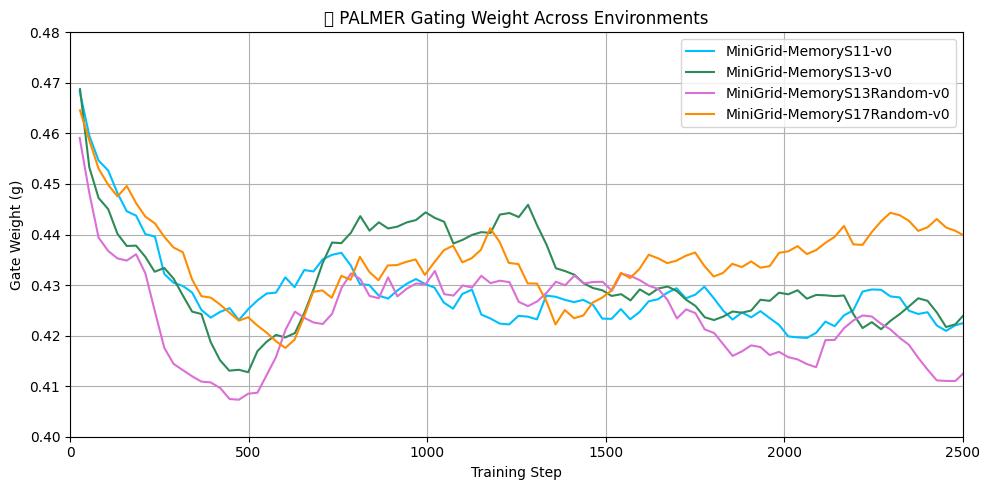

In [25]:
# --- Environments ---
PALMER_ENV_NAMES = [
    "MiniGrid-MemoryS11-v0",
    "MiniGrid-MemoryS13-v0",
    "MiniGrid-MemoryS13Random-v0",
    "MiniGrid-MemoryS17Random-v0"
]

# --- Color map for environments ---
ENV_COLORS = {
    "MiniGrid-MemoryS11-v0": "deepskyblue",
    "MiniGrid-MemoryS13-v0": "seagreen",
    "MiniGrid-MemoryS13Random-v0": "orchid",
    "MiniGrid-MemoryS17Random-v0": "darkorange"
}

plt.figure(figsize=(10, 5))

for env_name in PALMER_ENV_NAMES:
    run = next((r for r in api.runs(f"{ENTITY}/{PROJECT}") if env_name in r.name and "palmer" in r.name), None)
    if run is None:
        print(f"No PALMER run found for {env_name}")
        continue
    hist = run.history(keys=["_step", "gates/agf_value"])
    plt.plot(hist["_step"], hist["gates/agf_value"], label=env_name, color=ENV_COLORS[env_name])

plt.title("PALMER Gating Weight Across Environments")
plt.xlabel("Training Step")
plt.ylabel("Gate Weight (g)")
plt.ylim(0.4, 0.48)
plt.xlim(0, 2500)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Conclusion
In this demo, we explored PALMER, a memory-augmented reinforcement learning agent combining LSTM and Transformer modules via adaptive gating. We evaluated its performance against PPO-LSTM and PPO-TrXL across four MiniGrid-Memory environments. Results show that PALMER performs competitively in deterministic tasks and offers dynamic memory balancing through its learned gating mechanism. We also visualized training curves, memory usage, loss trends, and agent behaviors using interactive videos and Weights & Biases tracking. This demonstration highlights PALMER’s potential in memory-demanding tasks and provides an open, reproducible platform for further research in memory-efficient RL.

